In [1]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




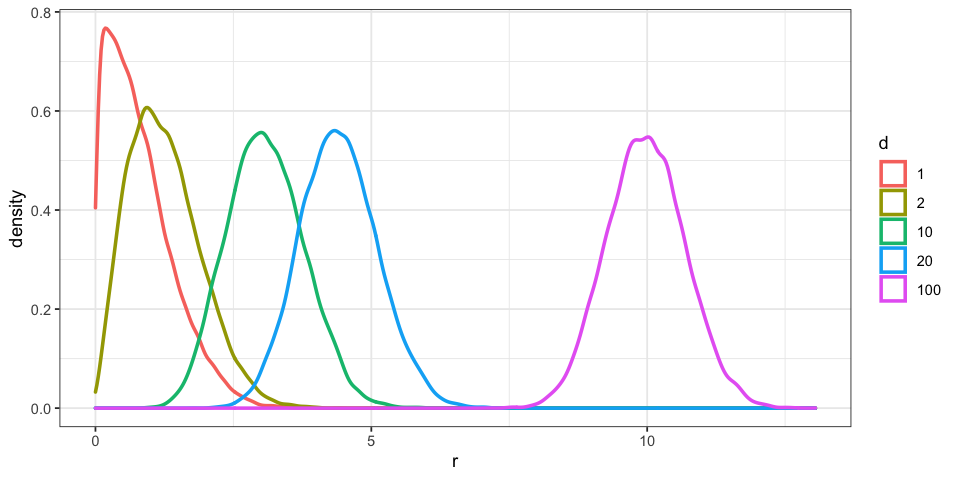

In [2]:
sample_distance_from_origin <- function(d, n=20000) {
    x <- matrix(rnorm(n*d), nrow=n)
    r <- sqrt(rowSums(x^2))
    r
}

x <- NULL
for (d in c(1,2,10,20,100)) {
    r <- sample_distance_from_origin(d)
    tmp <- data.frame(d=d, r=r)
    x <- rbind(x, tmp)
}
x$d <- factor(x$d)

options(repr.plot.width=8, repr.plot.height=4)
ggplot(x, aes(r, color=d)) + geom_density(size=1) + theme_bw()

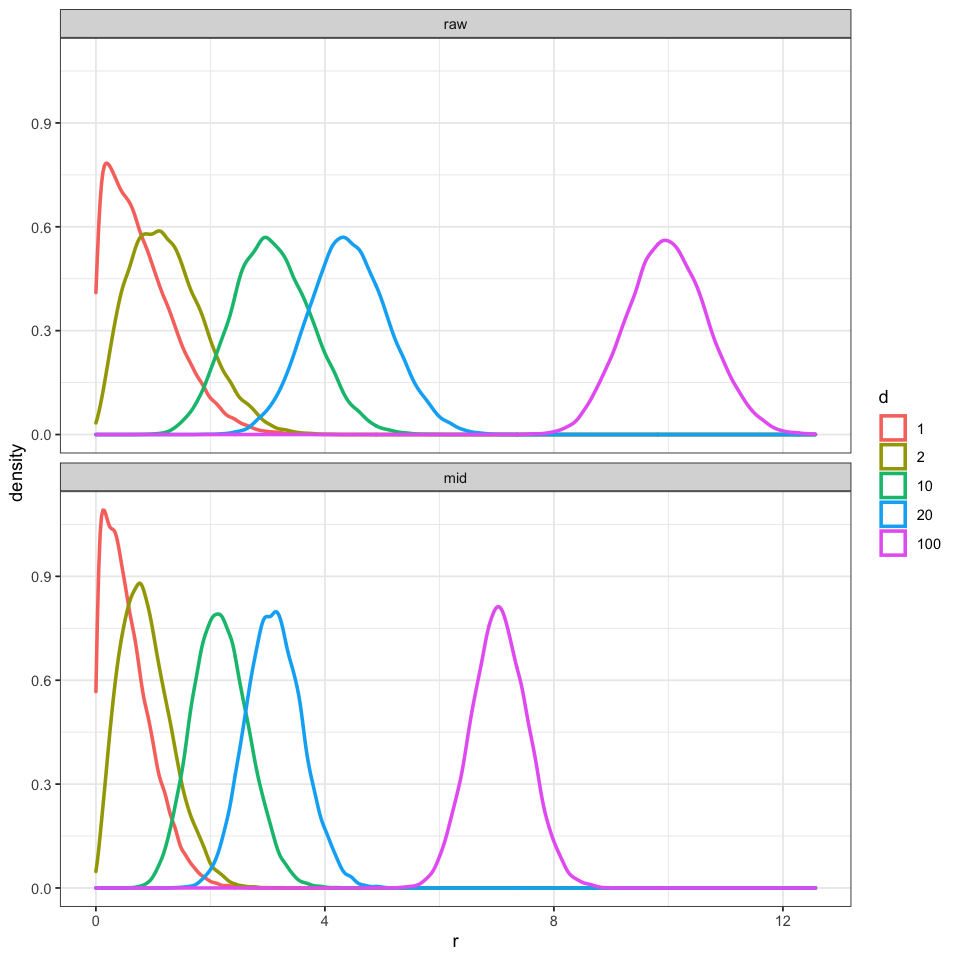

In [3]:
sample_distance_from_origin_midpoint <- function(d, n=20000) {
    x1 <- matrix(rnorm(n*d), nrow=n)
    x2 <- matrix(rnorm(n*d), nrow=n)
    x <- (x1 + x2) / 2
    r <- sqrt(rowSums(x^2))
    r
}

x <- NULL
for (d in c(1,2,10,20,100)) {
    r <- sample_distance_from_origin(d)
    tmp <- data.frame(d=d, type="raw", r=r)
    x <- rbind(x, tmp)
    
    r <- sample_distance_from_origin_midpoint(d)
    tmp <- data.frame(d=d, type="mid", r=r)
    x <- rbind(x, tmp)    
}
x$d <- factor(x$d)
x$type <- factor(x$type, levels=c("raw", "mid"))

options(repr.plot.width=8, repr.plot.height=8)
ggplot(x, aes(r, color=d)) + geom_density(size=1) + facet_wrap(vars(type), ncol=1) + theme_bw()

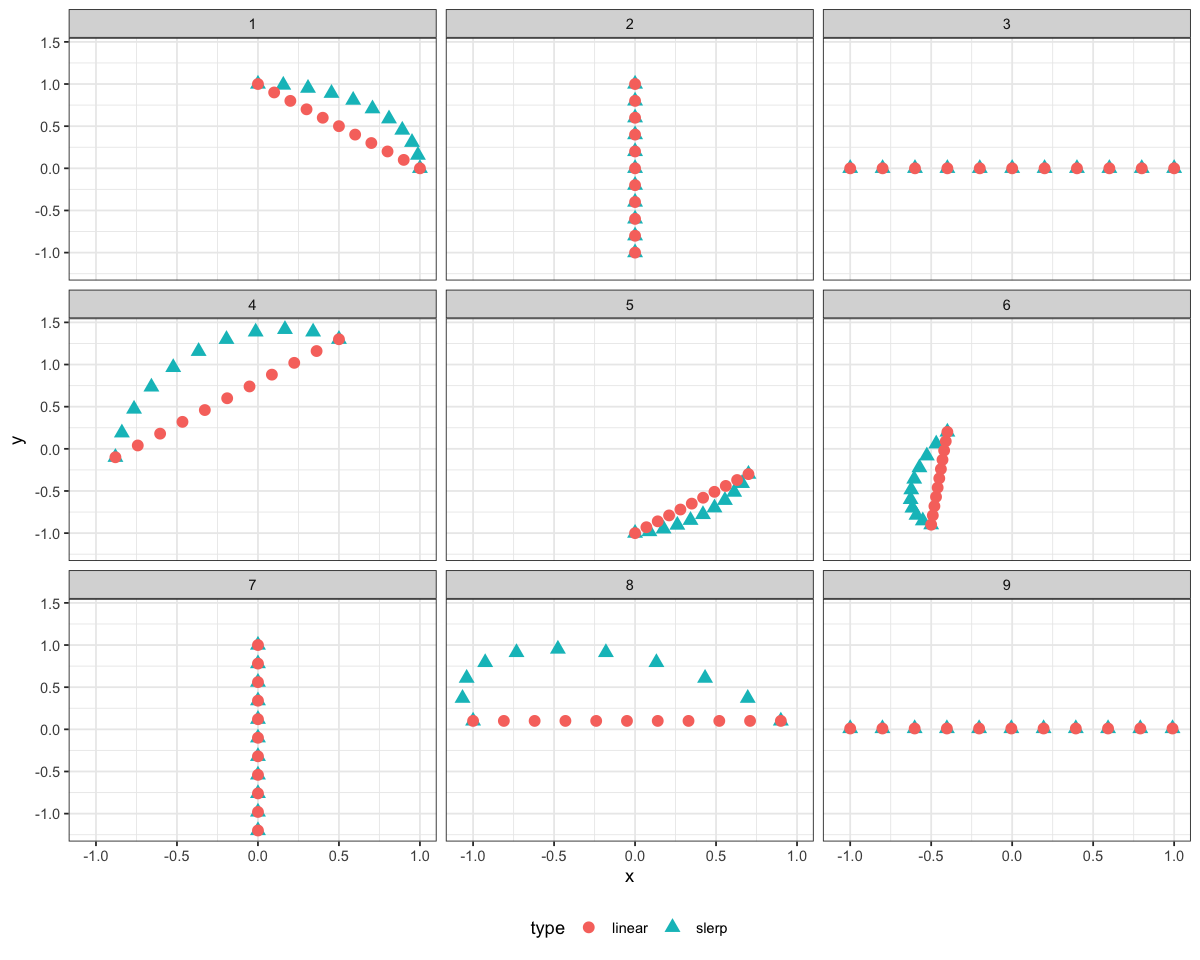

In [4]:
slerp <- function(p0, p1, ts, dot_thres=0.9995) {
    # returns interpolated position between p0 and p1
    # t is the closeness to p1
    # t=0 -> p0, t=1 -> p1
    # t in (0,1) -> somewhere between them
    # cf: https://en.wikipedia.org/wiki/Slerp
    norm0 <- sqrt(sum(p0^2))
    norm1 <- sqrt(sum(p1^2))
    dot <- sum((p0/norm0) * (p1/norm1))
    if (abs(dot) > dot_thres) {
        t(sapply(ts, function(t) { (1-t)*p0 + t*p1 }))
    } else {
        omega <- acos(max(-1, min(1, dot)))
        sinomega <- sin(omega)
        t(sapply(ts, function(t) { sin((1-t)*omega) / sinomega * p0 + sin(t*omega) / sinomega * p1} ))
    }
}

interpolate <- function(p0, p1, ts) {
    t(sapply(ts, function(t) { (1-t)*p0 + t*p1 }))
}


points <- list(
    list(c(0, 1), c(1, 0)),
    list(c(0, 1), c(0, -1)),
    list(c(1, 0), c(-1, 0)),
    list(c(-0.88, -0.1), c(0.5, 1.3)),
    list(c(0, -1), c(0.7, -0.3)),
    list(c(-0.4, 0.2), c(-0.5, -0.9)),
    list(c(0, 1), c(0, -1.2)),
    list(c(-1, 0.1), c(0.9, 0.1)),
    list(c(-1, 0.01), c(0.99, 0.01))
)
x <- NULL
for (i in seq_along(points)) {
    p <- points[[i]]
    tmp <- slerp(p[[1]], p[[2]], seq(0, 1, by=0.1))
    tmp <- as.data.frame(tmp)
    names(tmp) <- c("x", "y")
    tmp$example <- i
    tmp$type <- "slerp"
    x <- rbind(x, tmp)

    tmp <- interpolate(p[[1]], p[[2]], seq(0, 1, by=0.1))
    tmp <- as.data.frame(tmp)
    names(tmp) <- c("x", "y")
    tmp$example <- i
    tmp$type <- "linear"
    x <- rbind(x, tmp)

}

options(repr.plot.width=10, repr.plot.height=8)
ggplot(x, aes(x, y, color=type, shape=type)) + 
    geom_point(size=3) + facet_wrap(vars(example)) +
    theme_bw() + theme(legend.position="bottom")        

In [5]:
sample_distance_from_origin_slerpmid <- function(d, n=20000) {
    x1 <- matrix(rnorm(n*d), nrow=n)
    x2 <- matrix(rnorm(n*d), nrow=n)
    r <- rep(NA, n)
    for (i in 1:n) {
        x <- slerp(x1[i,], x2[i,], 0.5)
        r[i] <- sqrt(sum(x^2))
    }
    r
}

x <- NULL
for (d in c(1,2,10,20,100)) {
    r <- sample_distance_from_origin(d)
    tmp <- data.frame(d=d, type="raw", r=r)
    x <- rbind(x, tmp)
    
    r <- sample_distance_from_origin_midpoint(d)
    tmp <- data.frame(d=d, type="mid", r=r)
    x <- rbind(x, tmp)
    
    r <- sample_distance_from_origin_slerpmid(d)
    tmp <- data.frame(d=d, type="slerpmid", r=r)
    x <- rbind(x, tmp)    
}
x$d <- factor(x$d)
x$type <- factor(x$type, levels=c("raw", "mid", "slerpmid"))

type,max(r),min(r)
<fct>,<dbl>,<dbl>
raw,12.653090,6.829755e-06
mid,9.199072,1.915574e-05
slerpmid,87.521151,6.291337e-05


Warning message:
“Removed 141 rows containing non-finite values (stat_density).”


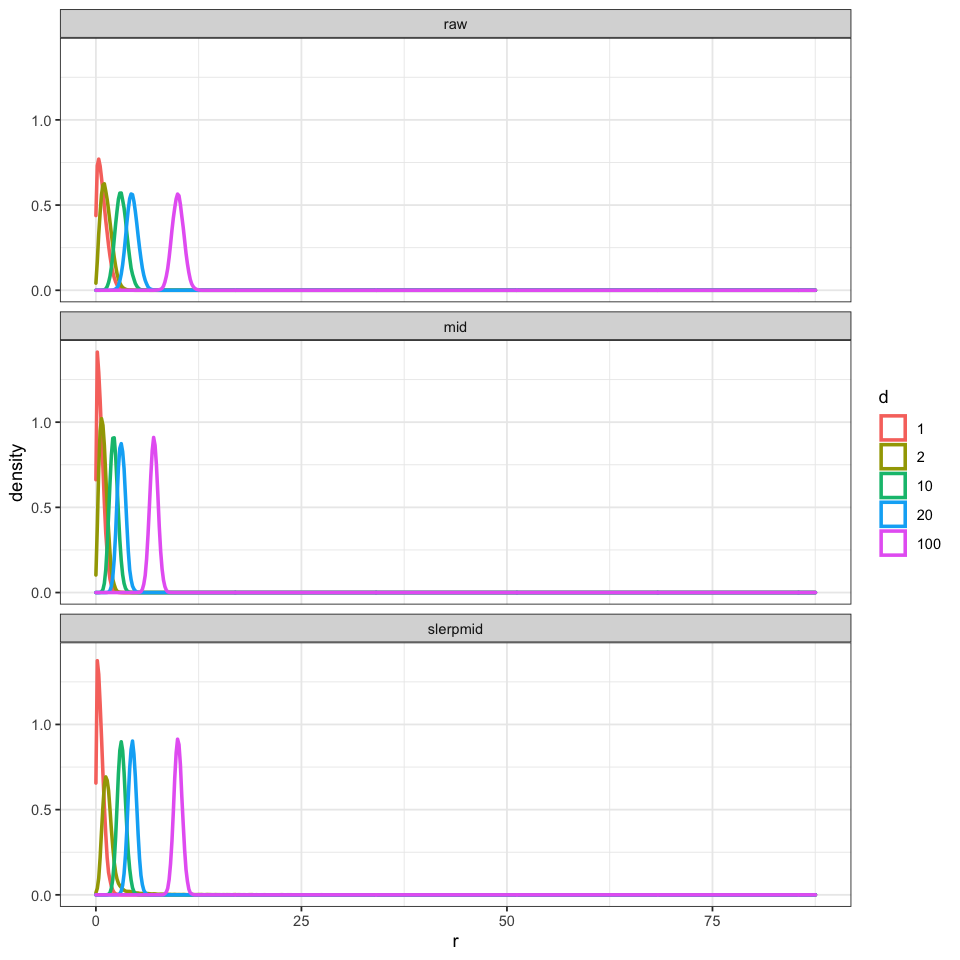

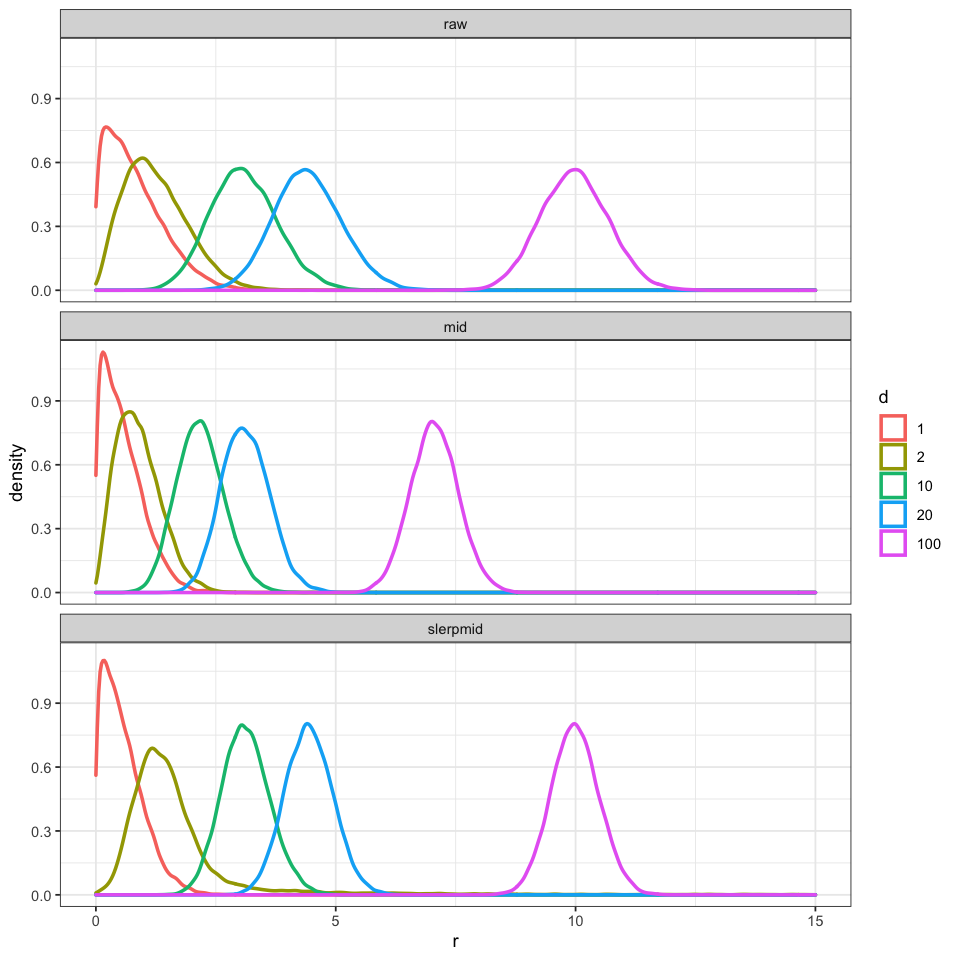

In [6]:
group_by(x, type) %>%
  summarize(max(r), min(r))

options(repr.plot.width=8, repr.plot.height=8)
ggplot(x, aes(r, color=d)) + geom_density(size=1) +
  facet_wrap(vars(type), ncol=1) + 
  theme_bw()

# remove outliers
options(repr.plot.width=8, repr.plot.height=8)
ggplot(x, aes(r, color=d)) + geom_density(size=1) +
  facet_wrap(vars(type), ncol=1) + 
  xlim(c(0, 15)) +
  theme_bw()